In [19]:
# =========================================================
# Imports
# =========================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import signal

# =========================================================
# Funtions
# =========================================================

def read_raw_data_as_pandas_df(raw_data_file_path):

    # Read file with timestamp as index
    precip = pd.read_csv(raw_data_file_path, encoding="ISO-8859-1",index_col=1)

    # Timestamps str -> datetime
    precip.index = pd.to_datetime(precip.index)

    # Save ID of station
    station_id = str(precip.station.iloc[0])

    # Remove column with station ID
    precip = precip.drop("station",axis=1) 

    return precip,station_id

def pad_dateframe_w_0_values(df):

    # Complete list of dates
    dates = pd.date_range(df.index[0],df.index[-1],freq="min")

    # Add additional timestamps with a value of 0
    df = df.reindex(dates,fill_value=0)
    
    return df

def get_events(precip):
    
    # Size of timesteps
    time_delta = precip.index[1]-precip.index[0]

    # Rolling 11 hour sum
    precip_sum = precip.rolling('11h').sum()

    # dates with no precip last 11 hours
    dates_w_zero_sum = precip_sum.index[(precip_sum.mask(precip_sum!=0)==precip_sum).values[:,0]]

    # Add first date with rain
    for date in precip.index:
        if precip.loc[date].values[0] != 0:
            start_dates = [date]
            break

    # Save start and end dates
    end_dates   = []
    for date in tqdm(dates_w_zero_sum):
        if precip_sum.loc[date- time_delta].values[0]!=0:
            end_dates += [date- pd.Timedelta(hours=11)]
        if precip_sum.loc[date+ time_delta].values[0]!=0:
            start_dates += [date+ time_delta]
    
    # Add end to last event
    for date in reversed(precip.index):  # Iterate from last to first
        if precip.loc[date].values[0] != 0:  # Check if value is not zero
            end_dates += [date]
            break  # Stop at the first nonzero value
    
    # Save events as list of tuples
    events = []
    for i in range(len(end_dates)):
        events+=[(start_dates[i],end_dates[i])]
    
    return events

def filter_by_length(events_list,min_duration):

    events = [event for event in events_list if event[1]-event[0]>=pd.Timedelta(minutes=min_duration)]

    return events

def filter_by_amount(events_list,padded_precip,min_precip):

    events = [event for event in events_list if padded_precip.loc[event[0]:event[1]].sum().values[0]>=min_precip]
    return events

def key_numbers_for_events(events_list,padded_precip):
    
    # Max precipitation [mm/min]
    max_values = np.array([padded_precip.loc[event[0]:event[1]].max().values[0] for event in events_list])
    
    # Sum of precipiation [mm]
    amount = np.array([padded_precip.loc[event[0]:event[1]].sum().values[0] for event in events_list])

    # Duration [min]
    duration = np.array([1+(event[1]-event[0]).days*24*60+(event[1]-event[0]).seconds/60 for event in events_list])

    # non zero percentage
    non_zero_vals_percent = np.array([(padded_precip.loc[event[0]:event[1]].values!=0).sum() for event in events_list])
    non_zero_vals_percent = non_zero_vals_percent*100 / duration
    return max_values,amount,duration,non_zero_vals_percent

def moving_average(x, w):
    # Moving avg mirror edges
    start = np.zeros(int((w-1)/2))
    if w%2==0:
        end = np.zeros(1+int((w-1)/2))
    else:
        end = np.zeros(int((w-1)/2))    
    
    for i in range(0,int((w-1)/2)):
        sum1 = 0
        sum2 = 0
        for j in range(0,int((w-1)/2)+1+i):
            sum1 = sum1 + x[j]
            sum2 = sum2 + x[-j-1]
        start[i] = sum1/(j+1)
        end[-i-1]   = sum2/(j+1) 
        
    MA = np.append(start,np.convolve(x, np.ones(w), mode='valid') / w)
    MA = np.append(MA,end)
    
    return MA

def plot_all_events(precip_padded,events):
    plt.figure()
    plt.plot(precip_padded.index,precip_padded.values)
    for i,dates in enumerate(events):
        plt.vlines(dates[0],colors="green",linestyles='--',ymin=0,ymax=3)
        plt.vlines(dates[1],colors="red",linestyles='--',ymin=0,ymax=3)
    plt.legend(["Precipitation","Event start","Event end"])
    plt.ylabel("[mm]")
    plt.title("Padded precip data, with events")

def plot_key_numbers_boxplot(amount,max_values,duration,non_zero):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # 2x2 grid of subplots

    # Plot 1: Summed Precipitation
    axes[0, 0].boxplot(amount)
    axes[0, 0].set_title("Summed precip [mm]")

    # Plot 2: Max Intensity
    axes[0, 1].boxplot(max_values)
    axes[0, 1].set_title("Max intensity [mm/min]")

    # Plot 3: Duration of Event
    axes[1, 0].boxplot(duration)
    axes[1, 0].set_title("Duration of event [min]")

    # Plot 4: Duration of Rain
    axes[1, 1].boxplot(non_zero)
    axes[1, 1].set_title("Duration of rain [%]")

    # Adjust layout for better spacing
    plt.tight_layout()

def plot_key_numbers_histogram(amount,max_values,duration,non_zero):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # 2x2 grid of subplots

    # Plot 1: Summed Precipitation
    axes[0, 0].hist(amount,bins=30)
    axes[0, 0].set_title("Summed precip [mm]")

    # Plot 2: Max Intensity
    axes[0, 1].hist(max_values,bins=30)
    axes[0, 1].set_title("Max intensity [mm/min]")

    # Plot 3: Duration of Event
    axes[1, 0].hist(duration,bins=30)
    axes[1, 0].set_title("Duration of event [min]")

    # Plot 4: Duration of Rain
    axes[1, 1].hist(non_zero,bins=30)
    axes[1, 1].set_title("Duration of rain [%]")

    # Adjust layout for better spacing
    plt.tight_layout()

def plot_event_w_MA(events,precip_padded,event_idx,window_size):

    # Size of timesteps
    time_delta = precip_padded.index[1]-precip_padded.index[0]
    time_delta_minuts = time_delta.seconds/60
    window_size = int(window_size/time_delta_minuts)

    plt.figure()
    event = (precip_padded.loc[events[event_idx][0]:events[event_idx][1]])
    mavg = moving_average(event.values[:,0],window_size)
    
    plt.bar(event.index,event.values[:,0],width=pd.Timedelta(minutes=time_delta_minuts))
    plt.plot(event.index,mavg,'-r')

    plt.legend(["Moving average","Precipitation"])
    plt.title("Single event with moving avg")


# =========================================================
# Input
# =========================================================

# Path to data file
raw_data_file = "/nfs/a319/gy17m2a/PhD/datadir/DanishRainData/Sample1.csv"

# minimum duration of event [min]
min_duration = 0

# minimum summed precipitation in event [mm] 
min_precip = 1

# resolution (original 1 min)
resolution = '1T' #xT is x minutes, ex '5T' is 5 minutes resolution

# Event idx to plot
event_idx=1

# Moving avg window size [min]
window_size=30

# =========================================================
# Script
# =========================================================

# Load data

precip, st_id = read_raw_data_as_pandas_df(raw_data_file_path = raw_data_file)

# Pad time series with 0 values
precip_padded = pad_dateframe_w_0_values(df = precip)

# Resample
precip_padded = precip_padded.resample(resolution).sum()

# Get events
events = get_events(precip=precip_padded)

# Filter events by minimum duration [min]
events = filter_by_length(events_list=events,min_duration=min_duration)

# Filter events by minimum precipitation [mm]
events = filter_by_amount(events_list=events,padded_precip=precip_padded,min_precip=min_precip)

# get key numbers for events
max_values,amount,duration,non_zero = key_numbers_for_events(events_list=events,padded_precip=precip_padded)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10842/10842 [00:03<00:00, 3587.79it/s]


In [26]:
# Why is it seelcting one event that lasts basically the whole time?

In [ ]:
### Is this supposed to show the start and end of each identified event?

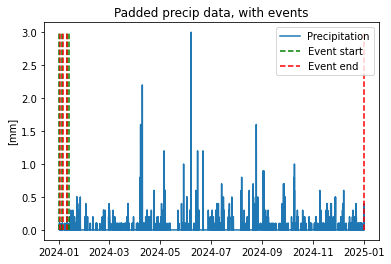

In [20]:
plot_all_events(precip_padded=precip_padded,events=events)

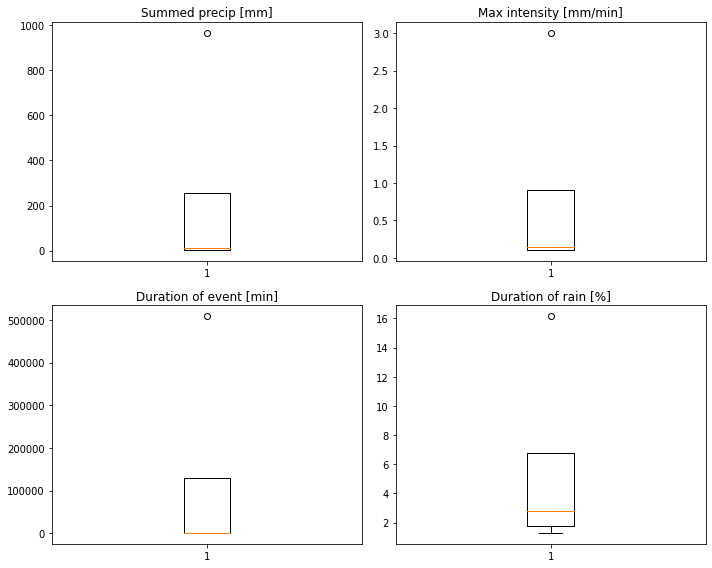

In [21]:
plot_key_numbers_boxplot(amount,max_values,duration,non_zero)

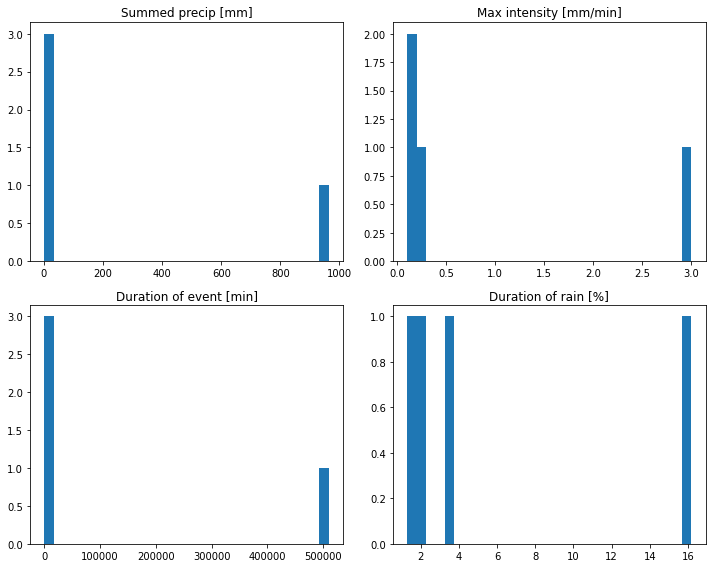

In [22]:
plot_key_numbers_histogram(amount,max_values,duration,non_zero)

In [24]:
### What is the moving average?

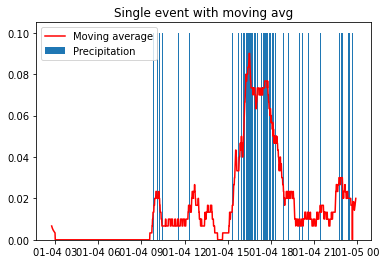

In [23]:
plot_event_w_MA(events=events,precip_padded=precip_padded,event_idx=event_idx,window_size=window_size)